# Разбор датасета WiseNET

In [50]:
from json import loads
from os import listdir
from os.path import join

import albumentations as A
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
from torch.utils.data import DataLoader, random_split
from ultralytics import YOLO

from src.config import (DATA_PATH, MOT20_EXT_FIRST_AXIS_MEAN,
                        MOT20_EXT_SECOND_AXIS_MEAN)
from src.tracker import show_detections, show_roi_detection
from src.train import get_config, get_dataset, test_siamese
from src.train.utils import (draw_reid_predict, get_binary_accuracy,
                             get_config, get_experiments, get_model)
from src.transforms import get_norm_transform, get_resize_transform

In [34]:
path = join(DATA_PATH, 'wisenet_dataset')
listdir(path)

['network_enviroment',
 'scripts',
 'LICENSE.txt',
 'video_sets',
 'manual_annotations',
 'automatic_annotations',
 'README.md']

## Пример двух камер с пересечением

Загрузка детектора

In [35]:
detector = YOLO('yolov8n.pt')

Данные по калиброке - местоположение камер

In [36]:
def parse(file_name):
    with open(file_name) as f:
        return loads(f.read())

In [37]:
calibration_path = join(path, 'network_enviroment',
                        'camera_calibration', '1280_720')
listdir(calibration_path)
calibration_data = list(
    map(lambda f: (parse(join(calibration_path, f)), f), listdir(calibration_path)))
calibration_data.sort(key=lambda x: x[1])
calibration_data

[({'regionsOfInterest': [{'regionOfInterest': 'RegionOfInterest_1',
     'xywh': [815, 26, 252, 687],
     'represents': 'IfcDoor_588559'},
    {'regionOfInterest': 'RegionOfInterest_2',
     'xywh': [257, 7, 437, 495],
     'represents': 'IfcDoor_589362'}],
   'deviceID': 'SmartCamera_1',
   'isHostedBy': 'IfcSpace_102572',
   'resolution': [{'height': 720.0, 'width': 1280.0}]},
  'cam_1.json'),
 ({'regionsOfInterest': [{'regionOfInterest': 'RegionOfInterest_3',
     'xywh': [287, 147, 24, 112],
     'represents': 'IfcDoor_588559'},
    {'regionOfInterest': 'RegionOfInterest_4',
     'xywh': [325, 149, 37, 167],
     'represents': 'IfcDoor_588624'},
    {'regionOfInterest': 'RegionOfInterest_5',
     'xywh': [523, 173, 121, 455],
     'represents': 'IfcDoor_588754'},
    {'regionOfInterest': 'RegionOfInterest_13',
     'xywh': [183, 270, 115, 430],
     'represents': 'IfcDoor_588175'}],
   'deviceID': 'SmartCamera_2',
   'isHostedBy': 'IfcSpace_102572',
   'resolution': [{'height': 72

Загрузка топологической карты (чтобы автоматически смотреть какие регионы интереса пересекаются)

Загрузка видео

In [38]:

# videos

Объединение калибровок и видео

Загрузка сиамской

In [39]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])
test_dataset_config = get_config('mot20_ext-test-v2')
test_set, _ = random_split(get_dataset(test_dataset_config, transform), [
                          test_dataset_config['dataset_use'], 1 - test_dataset_config['dataset_use']])
test_loader = DataLoader(test_set)

In [40]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [41]:
df = get_experiments().sort_values('best_val_acc', ascending=False)
best = df[df['datetime'] == '2023-05-16 21:04:15.317697']
model = get_model(best)

In [ ]:
td1 = test_siamese(model, test_loader, device)
get_binary_accuracy(td1, 0.25)

100%|██████████| 6946/6946 [02:14<00:00, 51.80it/s]


0.48430751511661385

In [42]:
draw_reid_predict(td1)

NameError: name 'td1' is not defined

In [43]:
threshold = 9

Алгоритм обработки:

    - одновременно читаем кадры с видео
    - сохраняем в трекеры deep sort 
    - если детекция уходит в регион интереса:
      - смотрим какие регионы интересов есть у данной камеры
      - смотрим, у каких еще камер есть регионы интересов
      - (временный вариант) сохраняем изображение 
      - ищем детекцию на связанной камере
      - первую же детекцию (в идеале - ближайшую к координате) - сопостовляем сиамской
      - пишем в трек id старого трека или создаем новый

In [44]:
def handle_boxes(boxes):
    boxes2 = boxes.copy()
    boxes2['left'] = boxes2['x1']
    boxes2['top'] = boxes2['y1']
    boxes2['w'] = boxes2['x2'] - boxes2['x1']
    boxes2['h'] = boxes2['y2'] - boxes2['y1']
    # boxes2 = boxes2.drop(labels=['confidence', 'class', 'x2', 'y2', 'x1', 'y1'], axis=1)
    return list(zip(zip(
        boxes2['left'].values,
        boxes2['top'].values,
        boxes2['w'].values,
        boxes2['h'].values
    ), boxes2['confidence'], boxes2['class']))

In [45]:
def get_iou(box1, box2):
    x_11 = box1[0]
    x_21 = x_11 + box1[2]
    y_11 = box1[1]
    y_21 = y_11 + box1[3]
    x_12 = float(box2[0])
    x_22 = x_12 + float(box2[2])
    y_12 = float(box2[1])
    y_22 = y_12 + float(box2[3])
    S_overlap = max(0, min(x_21, x_22) - max(x_11, x_12)) * \
        max(0, min(y_21, y_22) - max(y_11, y_12))
    S_union = box1[3] * box1[2] + box2[3] * box2[2] - S_overlap
    return S_overlap / S_union

In [59]:
# for cap, calibration, name in camera_data:
#     cap.release()

videoset_path = join(path, 'video_sets', 'set_1')
videos = list(map(lambda n: (cv2.VideoCapture(
    join(videoset_path, n)), n), listdir(videoset_path)))
videos.sort(key=lambda x: x[1])
camera_data = list(map(lambda x: (x[0][0], x[1][0], x[1][1].split('.')[
                   0]), zip(videos, calibration_data)))
# camera_data[2][0].read()

trackers = {}

# создаем трекеры для каждой камеры
for cap, calibration, name in camera_data:
    trackers[name] = DeepSort(max_age=30)

frame_index = 0

while True:
    # словарь текущих детекций для каждой камеры
    detections = {}
    # для каждого кадра получаем список детекций и обновляем трекеры
    for cap, calibration, name in camera_data:
        frame = cap.read()[1]
        res = detector.predict(frame, imgsz=1280, classes=[0])
        bbs = handle_boxes(pd.DataFrame(
            res[0].boxes.data.cpu(),
            columns=['x1', 'y1', 'x2', 'y2', 'confidence', 'class']
        ))
        # сохраненине детекции
        detections[name] = bbs
        # обновление трека сортом
        tracks = trackers[name].update_tracks(raw_detections=bbs, frame=frame)

    # создаем словарь всех регионов интереса
    match_roi = {}
    # проходим по всем камерам
    for cap, calibration, name in camera_data:
        # проходим по всем регионам интересов
        for camera_roi in calibration['regionsOfInterest']:
            if (camera_roi['represents'] not in match_roi):
                match_roi[camera_roi['represents']] = []
            # здесь будут храниться детекции данного региона
            matched_detection = []
            for box, conf, class_id in detections[name]:
                iou = get_iou(
                    list(map(float, camera_roi['xywh'])), list(map(float, box)))
                # сохранили детекции с достаточной iou
                if (iou > 1e-2):
                    matched_detection.append((box, name, iou))
            match_roi[camera_roi['represents']] += (matched_detection)

    # обходим все детекции и сравниваем каждую с каждой
    for roi, det in zip(match_roi, match_roi.values()):
        for i in range(len(det)):
            for j in range(i, len(det)):
                if (i == j): 
                    continue
                a, a_cam, a_iou = det[i]
                b, b_cam, b_iou = det[j]
                # если это детекции с одной камеры - пропускаем
                if (a_cam == b_cam):
                    continue
                predict = model(a, b)
                pass

    print(f'frame - {frame_index}')
    frame_index += 1
            
    # show_roi_detection(frame, list(map(float, box)), list(map(float, roi['xywh'])))


0: 736x1280 (no detections), 273.4ms
Speed: 6.8ms preprocess, 273.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 254.4ms
Speed: 5.7ms preprocess, 254.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 196.2ms
Speed: 4.7ms preprocess, 196.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 2 persons, 199.6ms
Speed: 4.1ms preprocess, 199.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 184.5ms
Speed: 4.2ms preprocess, 184.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


frame - 0



0: 736x1280 (no detections), 187.9ms
Speed: 3.4ms preprocess, 187.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 177.1ms
Speed: 3.7ms preprocess, 177.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 172.3ms
Speed: 3.9ms preprocess, 172.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 4 persons, 172.2ms
Speed: 3.8ms preprocess, 172.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 2 persons, 196.8ms
Speed: 4.4ms preprocess, 196.8ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)


frame - 1



0: 736x1280 (no detections), 180.4ms
Speed: 3.9ms preprocess, 180.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 277.9ms
Speed: 3.4ms preprocess, 277.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 199.5ms
Speed: 4.1ms preprocess, 199.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 4 persons, 174.3ms
Speed: 3.7ms preprocess, 174.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 184.6ms
Speed: 3.4ms preprocess, 184.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


frame - 2



0: 736x1280 (no detections), 189.3ms
Speed: 3.7ms preprocess, 189.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 183.2ms
Speed: 4.7ms preprocess, 183.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 181.6ms
Speed: 4.2ms preprocess, 181.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 4 persons, 189.3ms
Speed: 3.4ms preprocess, 189.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 3 persons, 209.4ms
Speed: 4.2ms preprocess, 209.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1280, 1280)


frame - 3



0: 736x1280 (no detections), 209.7ms
Speed: 4.1ms preprocess, 209.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 174.0ms
Speed: 4.1ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1280, 1280)

0: 736x1280 (no detections), 182.9ms
Speed: 3.5ms preprocess, 182.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1280)



KeyboardInterrupt: 

In [49]:
a = (1129.0178, 226.91461, 90.91748, 105.6676)
b = (1130.2505, 226.90005, 89.4082, 72.82294)
frame = 14
videoset_path = join(path, 'video_sets', 'set_1')
videos = list(map(lambda n: (cv2.VideoCapture(
    join(videoset_path, n)), n), listdir(videoset_path)))
videos.sort(key=lambda x: x[1])
camera_data = list(map(lambda x: (x[0][0], x[1][0], x[1][1].split('.')[
                   0]), zip(videos, calibration_data)))
pd.DataFrame([a])

,0,1,2,3
0,1129.0178,226.91461,90.91748,105.6676


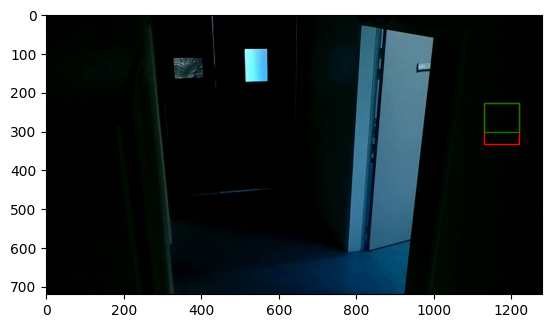

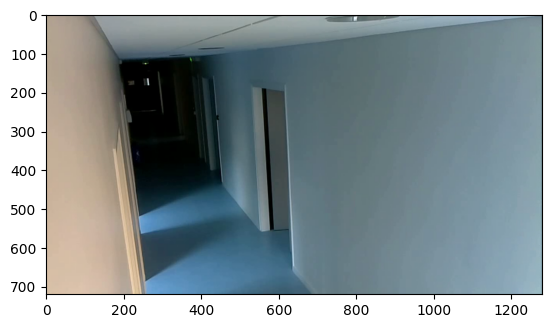

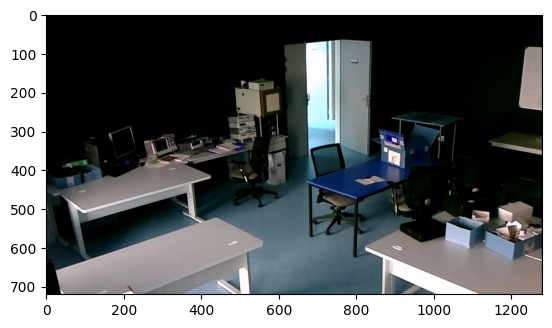

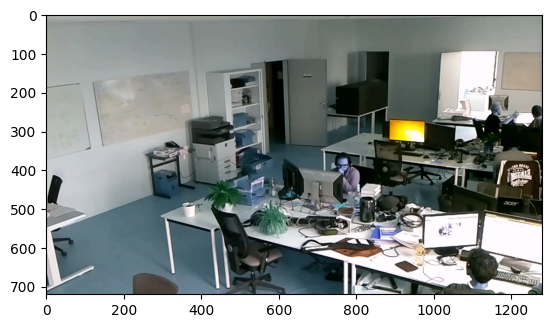

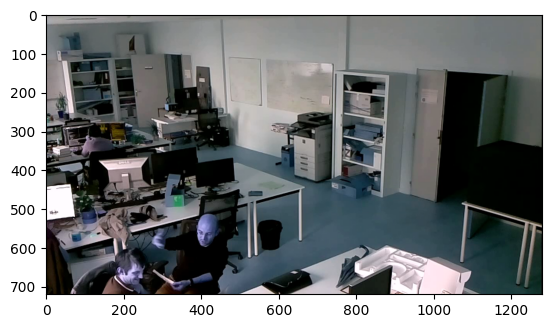

In [55]:
_, ax = plt.subplots()
for cap, _, _ in camera_data:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    f = cap.read()[1]
    x, y, w, h = a
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    x, y, w, h = b
    rect = patches.Rectangle(
        (x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    plt.imshow(f)
    plt.show()

In [1]:
int(32.23)

32